## Classifier  approach
---
This approach assumes that quantifiers are learned as a group and that essentially each q quantifier example is a negative example for all other quantifiers q'.

The classifier is in effect a solver for which q makes the sentence "Q as are bs" most likely given an input scene s.

This enables us to use not only the quantifier quantify evaluation methods but the classifier in order to generate a teacher-student scheme.

## Imports

### my class imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from quants.quantifiers import *
from quants.models import Classifier

Using TensorFlow backend.


### Global imports

In [3]:
import numpy as np
import pandas as pd

### keras and TF imports

In [4]:
import tensorflow as tf

print("TensorFlow version: ", tf.__version__)

import keras

from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Embedding, Dense, Conv1D, Input, Bidirectional, RepeatVector, Dropout, LeakyReLU, Flatten
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD, Adam

TensorFlow version:  2.2.0


In [5]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
print("Keras backend: ", tf.python.keras.backend.backend())
tf.python.keras.backend.set_session(sess)
tf.config.list_logical_devices()


Keras backend:  tensorflow


[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

### Classifier models

In [15]:
class DDNNClassifier(Classifier):
    """ deep dense classifier model builder method """
    
    def build(self):
        model= Sequential()
        model.add(Dense(Quantifier.scene_len, activation="relu", name="input"))
        model.add(Dropout(0.25, name="dropout_1"))
        model.add(Dense(100, activation="relu", name="dense_2"))
        model.add(Dropout(0.25, name="dropout_2"))
        model.add(Dense(50, activation="relu", name="dense_3"))
        model.add(Dropout(0.25, name="dropout_3"))
        model.add(Dense(len(self._quantifiers), activation='softmax', name="softmax_1"))
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision(),
                                                                                  tf.keras.metrics.Recall()])
        return model

In [27]:
class DNNClassifier(Classifier):
    """ dense classifier model builder method """
    
    def build(self):
        model= Sequential()
        model.add(Dense(Quantifier.scene_len, activation="relu", name="input"))
        model.add(Dropout(0.5, name="dropout_1"))
        model.add(Dense(len(self._quantifiers), activation='softmax', name="softmax_1"))
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision(),
                                                                                  tf.keras.metrics.Recall()])
        return model

In [38]:
from tensorflow.keras import initializers
from keras.utils import np_utils

class CNNClassifier(Classifier):
    """ Convolutional classifier model builder method """

    def build(self):
        model = Sequential()
        model.add(Conv1D(filters=4, kernel_size=1,
                         kernel_initializer="constant",
                         use_bias=False,
                         input_shape=(Quantifier.scene_len, len(symbols)), name="conv_1"))
        model.add(Dropout(0.5, name="dropout_1"))
        model.add(Flatten())
        model.add(Dense(len(self._quantifiers),
                        # kernel_initializer="constant", trainable=False, 
                        use_bias=False,
                        activation='softmax', name="softmax_1"))
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision(),
                                                                                  tf.keras.metrics.Recall()])
        return model

    def prepare(self, scenes):
        return np_utils.to_categorical(scenes)

## Quantifier sets for learning

In [12]:
natural_quantifiers = [The(), Both(), No(), All(), Some(), Most()]

In [13]:
# unnatural_quantifiers = [MinMax(2, 10), MinMax(3, 6), Or([MinMax(2, 5), MinMax(10, 20)])]
unnatural_quantifiers = [MinMax(2, 5), MinMax(8, 10), MinMax(12, 15), MinMax(17, 20), MinMax(24, 30), MinMax(37, 50)]

In [41]:
classifier = CNNClassifier(natural_quantifiers)
# classifier = DNNClassifier(natural_quantifiers)
# classifier = DDNNClassifier(natural_quantifiers)
classifier.plot()
classifier.learn(epochs=500, verbose=1)

CNNClassifier model classifies ['All()' 'Both()' 'Most()' 'No()' 'Some()' 'The()']
Epoch 1/500
6000/6000 [==============================] - 1s 156us/step - loss: 0.9715 - precision_14: 0.6986 - recall_14: 0.1747
Epoch 2/500
6000/6000 [==============================] - 1s 145us/step - loss: 0.7232 - precision_14: 0.7540 - recall_14: 0.3458
Epoch 3/500
6000/6000 [==============================] - 1s 150us/step - loss: 0.6641 - precision_14: 0.7471 - recall_14: 0.4233
Epoch 4/500
6000/6000 [==============================] - 1s 144us/step - loss: 0.6252 - precision_14: 0.7456 - recall_14: 0.4725
Epoch 5/500
6000/6000 [==============================] - 1s 144us/step - loss: 0.6049 - precision_14: 0.7480 - recall_14: 0.5057
Epoch 6/500
6000/6000 [==============================] - 1s 148us/step - loss: 0.5905 - precision_14: 0.7498 - recall_14: 0.5311
Epoch 7/500
6000/6000 [==============================] - 1s 168us/step - loss: 0.5835 - precision_14: 0.7508 - recall_14: 0.5507
Epoch 8/500
60

6000/6000 [==============================] - 1s 151us/step - loss: 0.4537 - precision_14: 0.7801 - recall_14: 0.7282
Epoch 64/500
6000/6000 [==============================] - 1s 153us/step - loss: 0.4502 - precision_14: 0.7805 - recall_14: 0.7291
Epoch 65/500
6000/6000 [==============================] - 1s 144us/step - loss: 0.4438 - precision_14: 0.7808 - recall_14: 0.7300
Epoch 66/500
6000/6000 [==============================] - 1s 144us/step - loss: 0.4521 - precision_14: 0.7811 - recall_14: 0.7308
Epoch 67/500
6000/6000 [==============================] - 1s 144us/step - loss: 0.4477 - precision_14: 0.7815 - recall_14: 0.7317
Epoch 68/500
6000/6000 [==============================] - 1s 147us/step - loss: 0.4430 - precision_14: 0.7818 - recall_14: 0.7326
Epoch 69/500
6000/6000 [==============================] - 1s 148us/step - loss: 0.4478 - precision_14: 0.7822 - recall_14: 0.7335
Epoch 70/500
6000/6000 [==============================] - 1s 152us/step - loss: 0.4440 - precision_14: 

6000/6000 [==============================] - 1s 150us/step - loss: 0.4229 - precision_14: 0.7943 - recall_14: 0.7610
Epoch 126/500
6000/6000 [==============================] - 1s 158us/step - loss: 0.4130 - precision_14: 0.7945 - recall_14: 0.7613
Epoch 127/500
6000/6000 [==============================] - 1s 160us/step - loss: 0.4295 - precision_14: 0.7946 - recall_14: 0.7617
Epoch 128/500
6000/6000 [==============================] - 1s 180us/step - loss: 0.4231 - precision_14: 0.7948 - recall_14: 0.7620
Epoch 129/500
6000/6000 [==============================] - 1s 184us/step - loss: 0.4268 - precision_14: 0.7949 - recall_14: 0.7623
Epoch 130/500
6000/6000 [==============================] - 1s 177us/step - loss: 0.4185 - precision_14: 0.7951 - recall_14: 0.7626
Epoch 131/500
6000/6000 [==============================] - 1s 162us/step - loss: 0.4281 - precision_14: 0.7952 - recall_14: 0.7629
Epoch 132/500
6000/6000 [==============================] - 1s 171us/step - loss: 0.4268 - precisi

6000/6000 [==============================] - 1s 143us/step - loss: 0.4206 - precision_14: 0.8008 - recall_14: 0.7745
Epoch 188/500
6000/6000 [==============================] - 1s 144us/step - loss: 0.4147 - precision_14: 0.8008 - recall_14: 0.7746
Epoch 189/500
6000/6000 [==============================] - 1s 156us/step - loss: 0.4129 - precision_14: 0.8009 - recall_14: 0.7747
Epoch 190/500
6000/6000 [==============================] - 1s 154us/step - loss: 0.4124 - precision_14: 0.8010 - recall_14: 0.7749
Epoch 191/500
6000/6000 [==============================] - 1s 158us/step - loss: 0.4185 - precision_14: 0.8011 - recall_14: 0.7751
Epoch 192/500
6000/6000 [==============================] - 1s 140us/step - loss: 0.4059 - precision_14: 0.8012 - recall_14: 0.7752
Epoch 193/500
6000/6000 [==============================] - 1s 137us/step - loss: 0.4232 - precision_14: 0.8012 - recall_14: 0.7754
Epoch 194/500
6000/6000 [==============================] - 1s 138us/step - loss: 0.4149 - precisi

6000/6000 [==============================] - 1s 159us/step - loss: 0.4086 - precision_14: 0.8044 - recall_14: 0.7819
Epoch 250/500
6000/6000 [==============================] - 1s 139us/step - loss: 0.4075 - precision_14: 0.8044 - recall_14: 0.7820
Epoch 251/500
6000/6000 [==============================] - 1s 139us/step - loss: 0.4056 - precision_14: 0.8045 - recall_14: 0.7821
Epoch 252/500
6000/6000 [==============================] - 1s 154us/step - loss: 0.4175 - precision_14: 0.8045 - recall_14: 0.7822
Epoch 253/500
6000/6000 [==============================] - 1s 164us/step - loss: 0.4170 - precision_14: 0.8046 - recall_14: 0.7823
Epoch 254/500
6000/6000 [==============================] - 1s 163us/step - loss: 0.4056 - precision_14: 0.8046 - recall_14: 0.7824
Epoch 255/500
6000/6000 [==============================] - 1s 165us/step - loss: 0.4153 - precision_14: 0.8047 - recall_14: 0.7824
Epoch 256/500
6000/6000 [==============================] - 1s 186us/step - loss: 0.4177 - precisi

6000/6000 [==============================] - 1s 144us/step - loss: 0.4001 - precision_14: 0.8070 - recall_14: 0.7869
Epoch 312/500
6000/6000 [==============================] - ETA: 0s - loss: 0.3924 - precision_14: 0.8070 - recall_14: 0.78 - 1s 161us/step - loss: 0.3936 - precision_14: 0.8070 - recall_14: 0.7870
Epoch 313/500
6000/6000 [==============================] - 1s 144us/step - loss: 0.4063 - precision_14: 0.8071 - recall_14: 0.7871
Epoch 314/500
6000/6000 [==============================] - 1s 147us/step - loss: 0.4056 - precision_14: 0.8071 - recall_14: 0.7872
Epoch 315/500
6000/6000 [==============================] - 1s 143us/step - loss: 0.4123 - precision_14: 0.8072 - recall_14: 0.7872
Epoch 316/500
6000/6000 [==============================] - 1s 143us/step - loss: 0.4132 - precision_14: 0.8072 - recall_14: 0.7873
Epoch 317/500
6000/6000 [==============================] - 1s 170us/step - loss: 0.4011 - precision_14: 0.8072 - recall_14: 0.7874
Epoch 318/500
6000/6000 [======

6000/6000 [==============================] - 1s 147us/step - loss: 0.4118 - precision_14: 0.8087 - recall_14: 0.7904
Epoch 374/500
6000/6000 [==============================] - 1s 148us/step - loss: 0.4182 - precision_14: 0.8087 - recall_14: 0.7905
Epoch 375/500
6000/6000 [==============================] - 1s 151us/step - loss: 0.4030 - precision_14: 0.8088 - recall_14: 0.7905
Epoch 376/500
6000/6000 [==============================] - 1s 156us/step - loss: 0.4063 - precision_14: 0.8088 - recall_14: 0.7906
Epoch 377/500
6000/6000 [==============================] - 1s 150us/step - loss: 0.4117 - precision_14: 0.8088 - recall_14: 0.7906
Epoch 378/500
6000/6000 [==============================] - 1s 156us/step - loss: 0.4174 - precision_14: 0.8088 - recall_14: 0.7906
Epoch 379/500
6000/6000 [==============================] - 1s 172us/step - loss: 0.4038 - precision_14: 0.8088 - recall_14: 0.7907
Epoch 380/500
6000/6000 [==============================] - 1s 191us/step - loss: 0.4020 - precisi

6000/6000 [==============================] - 1s 152us/step - loss: 0.4078 - precision_14: 0.8100 - recall_14: 0.7930
Epoch 436/500
6000/6000 [==============================] - 1s 138us/step - loss: 0.3988 - precision_14: 0.8100 - recall_14: 0.7930
Epoch 437/500
6000/6000 [==============================] - 1s 162us/step - loss: 0.3995 - precision_14: 0.8100 - recall_14: 0.7930
Epoch 438/500
6000/6000 [==============================] - 1s 170us/step - loss: 0.4076 - precision_14: 0.8100 - recall_14: 0.7931
Epoch 439/500
6000/6000 [==============================] - 1s 174us/step - loss: 0.4100 - precision_14: 0.8100 - recall_14: 0.7931
Epoch 440/500
6000/6000 [==============================] - 1s 155us/step - loss: 0.4115 - precision_14: 0.8101 - recall_14: 0.7931
Epoch 441/500
6000/6000 [==============================] - 1s 146us/step - loss: 0.3987 - precision_14: 0.8101 - recall_14: 0.7932
Epoch 442/500
6000/6000 [==============================] - 1s 147us/step - loss: 0.4093 - precisi

6000/6000 [==============================] - 1s 142us/step - loss: 0.4128 - precision_14: 0.8111 - recall_14: 0.7951
Epoch 498/500
6000/6000 [==============================] - 1s 145us/step - loss: 0.4028 - precision_14: 0.8111 - recall_14: 0.7951
Epoch 499/500
6000/6000 [==============================] - 1s 145us/step - loss: 0.3950 - precision_14: 0.8111 - recall_14: 0.7951
Epoch 500/500
6000/6000 [==============================] - 1s 145us/step - loss: 0.3999 - precision_14: 0.8111 - recall_14: 0.7952
TRAIN
Evaluation metrics: 
6000/6000 [==============================] - 0s 36us/step
[0.27588961803913115, 0.8112308979034424, 0.7952876091003418]
6000/6000 [==============================] - 0s 14us/step
Confusion matrix: 
        All()  Both()  Most()  No()  Some()  The()
All()    1000       0       0     0       0      0
Both()      0     922       0     0       0     78
Most()      5       0     799     0     194      2
No()        0       0       0  1000       0      0
Some()     

In [36]:
# print(natural_classifier._model.get_layer(name="conv_1").input_shape,
#       natural_classifier._model.get_layer(name="conv_1").output_shape)
# natural_classifier._model.get_layer(name="conv_1").get_weights()
# print(natural_classifier._model.get_layer(name="softmax_1").input_shape,
#       natural_classifier._model.get_layer(name="softmax_1").output_shape)
# natural_classifier._model.get_layer(name="softmax_1").get_weights()

(None, 500, 4) (None, 500, 2)
(None, 1000) (None, 6)


[array([[ 0.1076507 ,  0.13008717, -0.01818368, -0.22356793, -0.00356855,
         -0.00904826],
        [-0.0006467 ,  0.0793877 ,  0.10010331, -0.095723  , -0.1381944 ,
          0.02341199],
        [ 0.09779829,  0.02340156, -0.00931393, -0.06722328,  0.0653357 ,
         -0.04348795],
        ...,
        [ 0.01721711,  0.1114671 , -0.07544132,  0.05401943, -0.07675583,
          0.1960058 ],
        [ 0.15859719, -0.02447802, -0.08564785, -0.07498336, -0.0054255 ,
         -0.02525638],
        [-0.00150776,  0.12157026, -0.02007886,  0.05680544, -0.05764136,
          0.01590555]], dtype=float32),
 array([ 0.26824734, -0.29823148,  1.1078876 , -0.544239  , -0.3411305 ,
        -0.3680084 ], dtype=float32)]

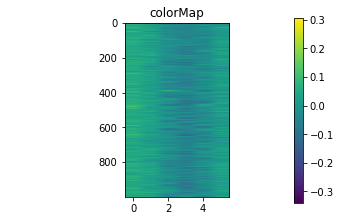

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(natural_classifier._model.get_layer(name="softmax_1").get_weights()[0])
ax.set_aspect(1 / 100)

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

In [173]:
# unnatural_classifier = teach(CNNClassifier(unnatural_quantifiers), epochs=50, max_len=10)
unnatural_classifier = DNNClassifier(unnatural_quantifiers).teach, epochs=50, max_len=100)

DNNClassifier model classifies ['MinMax(mini=12,maxi=15)' 'MinMax(mini=17,maxi=20)'
 'MinMax(mini=2,maxi=5)' 'MinMax(mini=24,maxi=30)'
 'MinMax(mini=37,maxi=50)' 'MinMax(mini=8,maxi=10)']
Epoch 1/50
600/600 [==============================] - 0s 404us/step - loss: 3.0381 - precision_38: 0.1388 - recall_38: 0.0970
Epoch 2/50
600/600 [==============================] - 0s 261us/step - loss: 1.8824 - precision_38: 0.1562 - recall_38: 0.0610
Epoch 3/50
600/600 [==============================] - 0s 259us/step - loss: 1.7974 - precision_38: 0.1565 - recall_38: 0.0364
Epoch 4/50
600/600 [==============================] - 0s 258us/step - loss: 1.7813 - precision_38: 0.1570 - recall_38: 0.0259
Epoch 5/50
600/600 [==============================] - 0s 271us/step - loss: 1.7926 - precision_38: 0.1587 - recall_38: 0.0204
Epoch 6/50
600/600 [==============================] - 0s 264us/step - loss: 1.7859 - precision_38: 0.1585 - recall_38: 0.0167
Epoch 7/50
600/600 [==============================] - 0s